In [7]:
import numpy as np
import os
import cv2

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
data_dir = "dataset"
categories=["boxer","French_bulldog","toy_terrier"]

In [10]:
training_data=[]
image_size=100

def create_trainig_data():
    for category in categories:
        path=os.path.join(data_dir,category)
        class_label=categories.index(category)
        try:
            for img in os.listdir(path):
                image_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array=cv2.resize(image_array,(image_size,image_size))                
                training_data.append([new_array,class_label])
        except Exception as e:
            print(e)
        
create_trainig_data()   


In [11]:
test_data=[]
image_size=100
data_dir = "dataset/test_set"
categories=["boxer","French_bulldog","toy_terrier"]

def create_test_data():
    for category in categories:
        path=os.path.join(data_dir,category)
        class_label=categories.index(category)
        try:
            for img in os.listdir(path):
                image_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                new_array=cv2.resize(image_array,(image_size,image_size))                
                test_data.append([new_array,class_label])
        except Exception as e:
            print(e)
        
create_test_data() 

In [12]:
print(np.shape(training_data))


(451, 2)


In [13]:
import random
random.shuffle(training_data)

In [14]:
def one_hot_encode(vec,vals=3):
    n=len(vec)
    out=np.zeros((n,vals))
    out[range(n),vec]=1
    return out

In [15]:
x_train=[]
y_train=[]

In [16]:
for feature,label in training_data:
    x_train.append(feature)
    y_train.append(label)
x_train=np.array(x_train).reshape(-1,image_size,image_size,1)    

In [17]:
x_test=[]
y_test=[]

for feature,label in test_data:
    x_test.append(feature)
    y_test.append(label)
x_test=np.array(x_test).reshape(-1,image_size,image_size,1)    

In [18]:
import pickle

pickle_out=open("X_train.pickle","wb")
pickle.dump(x_train,pickle_out)
pickle_out=open("y_train.pickle","wb")
pickle.dump(y_train,pickle_out)

In [19]:
pickle_in=open("X_train.pickle","rb")
x_train=pickle.load(pickle_in)

In [20]:
y_train=one_hot_encode(y_train)

In [21]:
y_test=one_hot_encode(y_test)

In [22]:
print(x_train.shape)
np.shape(y_train)
print(y_train[0:8,:])

(451, 100, 100, 1)
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


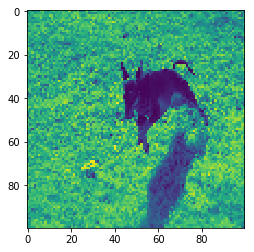

In [23]:
plt.imshow(x_train[0,:100,:100,0])

In [24]:
import tensorflow as tf

In [25]:
#Placeholders
x=tf.placeholder(tf.float32,shape=[None,image_size,image_size,1])
y=tf.placeholder(tf.float32,shape=[None,3])
hold_prob=tf.placeholder(tf.float32)

In [26]:
# Heper functions
def init_weights(shape):
    init_random_dist=tf.truncated_normal(shape=shape,stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_random_dist=tf.truncated_normal(shape=shape,stddev=0.1)
    return tf.Variable(init_random_dist)

def conv2d(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding="SAME")

def max_pool_2by2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")

def convolutional_layer(x,shape):
    w=init_weights(shape)
    b=init_bias([shape[3]])
    return tf.nn.relu(conv2d(x,w)+b)

def normal_full_layer(input_x,shape):
    input_size=int(input_x.get_shape()[1])
    w=init_weights([input_size,shape])
    b=init_bias([shape])
    return tf.matmul(input_x,w)+b

In [27]:
# layers
conv_1=convolutional_layer(x,shape=[4,4,1,32])
pooling_1=max_pool_2by2(conv_1)

In [28]:
conv_2=convolutional_layer(pooling_1,shape=[4,4,32,64])
pooling_2=max_pool_2by2(conv_2)

In [29]:
conv_2_flat=tf.reshape(pooling_2,shape=[-1,25*25*64])
full_layer_1=tf.nn.relu(normal_full_layer(conv_2_flat,1024))

In [30]:
# Dropout
full_dropout_1=tf.nn.dropout(full_layer_1,keep_prob=hold_prob)

In [31]:
y_pred=normal_full_layer(full_dropout_1,3)

In [32]:
# Loss function
cross_entropy=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [33]:
# Optimizer
optimizer=tf.train.AdamOptimizer(learning_rate=0.01)
train=optimizer.minimize(cross_entropy)

In [34]:
init=tf.global_variables_initializer()

In [36]:
# Graph operations
with tf.Session() as sess:
    sess.run(init)
    for i in range(1):
        sess.run(train,feed_dict={x:x_train,y:y_train,hold_prob:0.5})
    matches=tf.equal(tf.argmax(y_train,1),tf.argmax(y_pred,1))
    acc=tf.reduce_mean(tf.cast(matches,tf.float32))
    print("Accuracy: ",sess.run(acc,feed_dict={x:x_train,y:y_train,hold_prob:0.5}))
    matches=tf.equal(tf.argmax(y_test,1),tf.argmax(y_pred,1))
    acc=tf.reduce_mean(tf.cast(matches,tf.float32))
    print("prediction Accuracy: ",sess.run(acc,feed_dict={x:x_test,y:y_test,hold_prob:0.5}))   
    print("y_test: {0}  y_pred: {1}".format(y_test,sess.run(y_pred,feed_dict={x:x_test,y:y_test,hold_prob:0.5})))

Accuracy:  0.35698447
prediction Accuracy:  0.2580645
y_test: [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]  y_pred: [[ 3549.9055   -1148.3304    3222.8577  ]
 [ 1075.1344   -1618.2191    3616.3103  ]
 [ 2025.2678   -2443.0388    2331.2358  ]
 [  730.4572   -2014.2662    3291.5496  ]
 [ 2382.1394   -1159.7219     674.5787  ]
 [  882.76245   -548.1867    2379.587   ]
 [  703.266     -931.5273    3451.4458  ]
 [ 1013.0056    -865.3281    2787.441   ]
 [  766.6887   -1168.1993    1441.2654  ]
 [ 1986.5154    -945.73456   3320.2385  ]
 [ 3714.6726   -3747.502     5755.4604  ]
 [  252.51714  -1704.5896    3312.4343  ]
 [ 1555.4722   -2194.7058    2270.4373  ]
 [ 1813.53